In [1]:
import os
import sys
import json
import time
import pickle
import gspread
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar
from matplotlib.patches import Patch
from scipy import integrate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from PCIst.PCIst.pci_st import calc_PCIst, dimensionality_reduction

In [4]:
%matplotlib widget

Load CCF for identifying cortical areas

In [5]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [6]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [7]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
}

In [8]:
area_colors = {
    'MO': (31/255, 157/255, 90/255), # [31, 157, 90] 'blue'
    'ACA': (64/255, 166/255, 102/255), # [64, 166, 102] 'deepskyblue'
    'SS': (24/255, 128/255, 100/255), # [24, 128, 100] 'blueviolet'
    'VIS': (8/255, 133/255, 140/255), # [8, 133, 140] 'green'
    'MO-TH': (255/255, 112/255, 128/255), # [255, 112, 128] 'steelblue'
#     'VIS-TH': 'olivedrab'
}

In [9]:
# state_colors = {
#     'awake': (120/255, 156/255, 74/255),
#     'anesthetized': (130/255, 122/255, 163/255),
#     'recovery': (93/255, 167/255, 229/255)
# }
state_colors = {
    'resting': 'royalblue',
    'running': 'seagreen',
    'anesthetized': 'indianred',
}

#### Functions

In [10]:
def get_stim_event_inds(stim_table, stim_type, stim_param, sweep, trials='resting'):
    if trials == 'resting':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == True)
        ].index.values
    elif trials == 'running':
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True) &
            (stim_table['resting_trial'] == False)
        ].index.values
    else:
        return stim_table[
            (stim_table['stim_type'] == stim_type) &
            (stim_table['parameter'] == stim_param) &
            (stim_table['sweep'] == sweep) &
            (stim_table['good'] == True)
        ].index.values

In [11]:
def find_bursts_indunit(spike_times, ISImax=0.004):
    
    preISIs = np.diff(spike_times)[:-1]
    postISIs = np.diff(spike_times)[1:]
    ## Find starts ##
    bs_inds = np.nonzero((preISIs > 0.1) * (postISIs < ISImax))[0]
    if len(bs_inds) == 0:
        return np.array([]), np.array([])
    
    burst_starts = bs_inds + 1 # +1 corrects for the actual spike ind
    ## Loop through burst starts to find spikes that belong to the burst
    burst_counts = []
    for st_ind in bs_inds:
        spkind = st_ind+1
        bcount = 1
        while (spkind < len(preISIs)) and (preISIs[spkind] < 0.004):
            spkind += 1
            bcount += 1
        burst_counts.append(bcount)
    
    return spike_times[burst_starts], np.array(burst_counts)

## Load subjects from file

In [12]:
with open(r'C:\Users\lesliec\OneDrive - Allen Institute\data\all_iso_subjects_wPROBES.json') as subjects_file:
    multi_sub_dict = json.load(subjects_file)

In [13]:
for group, group_subs in multi_sub_dict.items():
    print(group)
    print('')
    for mouse_num, mdata in group_subs.items():
        print(' {}'.format(mouse_num))
        mdata['exp'] = EEGexp(mdata['data_loc'], preprocess=False, make_stim_csv=False)
    print('')

MOs_superficial

 575102
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

MOs_deep

 546655
Experiment type: electrical and sensory stimulation
 551399
Experiment type: electrical stimulation
SomnoSuite log file not found.
 551397
Experiment type: electrical and sensory stimulation
Body camera file not found.
Pupil camera file not found.
 569062
Experiment type: electrical and sensory stimulation
 569068
Experiment type: electrical and sensory stimulation
 569069
Experiment type: electrical and sensory stimulation
 569064
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 569073
Experiment type: electrical and sensory stimulation
 571619
Experiment type: electrical stimulation
SomnoSuite log file not found.

SSp_superficial

 571620
Experiment type: electrical and sensory stimulation
SomnoSuite log file not found.
 586466
Experiment type: el

In [14]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\burst_analyses'

## Testing one subject

In [15]:
current_levels = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [17]:
group = 'MOs_deep'
mouse_num = '569073' # could also try 569069, 569062

stim_area = group[:2]
stim_depth = group.split('_')[-1]
mdata = multi_sub_dict[group][mouse_num]
evoked_data_folder = os.path.join(mdata['exp'].data_folder, 'evoked_data')

## Load unit info ##
fn_units_info = os.path.join(evoked_data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_spikes = pickle.load(unit_file)
    with open(os.path.join(evoked_data_folder, 'units_event_spikes.pkl'), 'rb') as unit_file:
        all_unit_event_spikes = pickle.load(unit_file)
else:
    print('  {} not found. Not analyzing this subject\n.'.format(fn_units_stats))
    
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(mdata['exp'].mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(mdata['exp'].experiment_folder))))
)].squeeze()
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
        
## Load stim log (includes running speed now) ##
stim_log = pd.read_csv(mdata['exp'].stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})

## Get event inds ##
all_event_inds = {}
for leveli, parami in zip(current_levels, currents_list):
    all_event_inds[leveli] = {}
    for statei in test_states:
        sweeps = mdata['states'][statei]
        if not sweeps:
            continue
        if statei == 'awake':
            substates = ['resting', 'running']
            for substatei in substates:
                state_events = []
                for sweepi in sweeps:
                    events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials=substatei)
                    if len(events) == 0:
                        continue
                    state_events.append(events)
                all_event_inds[leveli][substatei] = np.concatenate(state_events)
        else:
            state_events = []
            for sweepi in sweeps:
                events = get_stim_event_inds(stim_log, 'biphasic', parami, sweepi, trials='all')
                if len(events) == 0:
                    continue
                state_events.append(events)
            all_event_inds[leveli][statei] = np.concatenate(state_events)

In [18]:
regdf = unit_info[(unit_info['parent'] == 'MO-TH')]
regdf.head()

,unit_id,cell_type,depth,region,parent
0,B0,RS,3500,VPM,MO-TH
1,B2,RS,3500,VPM,MO-TH
2,B14,RS,3460,VPM,MO-TH
3,B15,RS,3460,VPM,MO-TH
4,B17,FS,3440,VPM,MO-TH


In [19]:
len(regdf)

100

In [20]:
len(all_unit_spikes['B0']['spikes'])

76395

In [21]:
len(all_unit_event_spikes['event_spikes']['B0'])

2040

### Find total bursts using different ISIs

In [50]:
testISI = np.array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008])

In [51]:
reg_units = regdf['unit_id'].values
all_burst_counts = np.zeros((len(testISI), len(reg_units)), dtype=int)
for ii, uid in enumerate(reg_units):
    uspikesi = all_unit_spikes[uid]['spikes']
    for jj, tISI in enumerate(testISI):
        burstsi, burst_counts = find_bursts_indunit(uspikesi, ISImax=tISI)
        all_burst_counts[jj, ii] = len(burstsi)

In [52]:
np.sum(all_burst_counts[3,:] == 0)

2

<IPython.core.display.Javascript object>


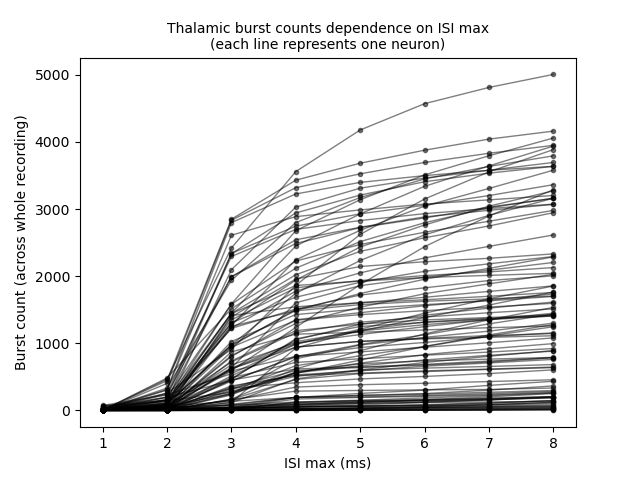

In [35]:
fig, ax = plt.subplots()
ax.plot(testISI*1E3, all_burst_counts, color='k', marker='.', linewidth=1.0, alpha=0.5)
ax.set_xlabel('ISI max (ms)')
ax.set_ylabel('Burst count (across whole recording)')
ax.set_title('Thalamic burst counts dependence on ISI max\n(each line represents one neuron)')

## Save ##
figname = 'totalburstcount_ISImax_{}-{}.png'.format(mouse_num, group)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

C:\Users\lesliec\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
C:\Users\lesliec\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


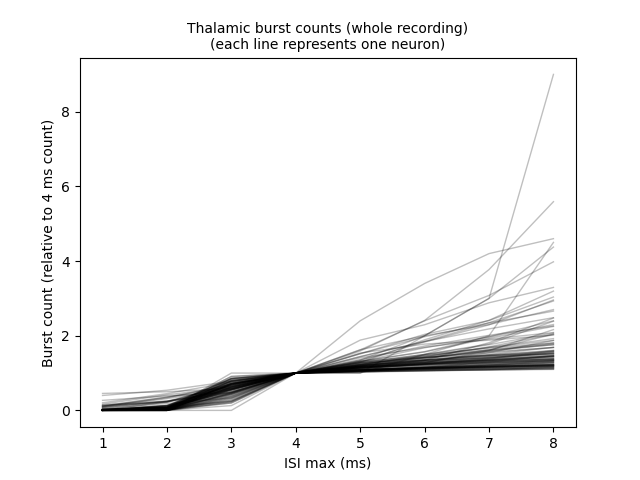

In [36]:
relative_count = all_burst_counts / all_burst_counts[3,:]

fig, ax = plt.subplots()
ax.plot(testISI*1E3, relative_count, color='k', linewidth=1.0, alpha=0.25)
ax.set_xlabel('ISI max (ms)')
ax.set_ylabel('Burst count (relative to 4 ms count)')
ax.set_title('Thalamic burst counts (whole recording)\n(each line represents one neuron)')

## Save ##
figname = 'RELburstcount_ISImax_{}-{}.png'.format(mouse_num, group)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

### Find event bursts using different ISI max values

In [41]:
testISI = np.array([0.003, 0.004, 0.005, 0.006])
test_window = [0.075, 0.3]

In [42]:
stimlevel = 'medium'
state = 'resting'

reg_units = regdf['unit_id'].values
all_burst_trials = np.zeros((len(testISI), len(reg_units)), dtype=float)
for ii, uid in enumerate(reg_units):
    ueventspikes = all_unit_event_spikes['event_spikes'][uid]
    for jj, tISI in enumerate(testISI):
        burst_present = np.zeros((len(all_event_inds[stimlevel][state])), dtype=int)
        for kk, evind in enumerate(all_event_inds[stimlevel][state]):
            eburstsi, eburst_counts = find_bursts_indunit(ueventspikes[evind], ISImax=tISI)
            if len(eburstsi) > 0:
                counts = np.nonzero((eburstsi >= test_window[0]) & (eburstsi <= test_window[1]))[0]
                if len(counts) > 0:
                    burst_present[kk] = 1
        all_burst_trials[jj, ii] = np.mean(burst_present)

<IPython.core.display.Javascript object>


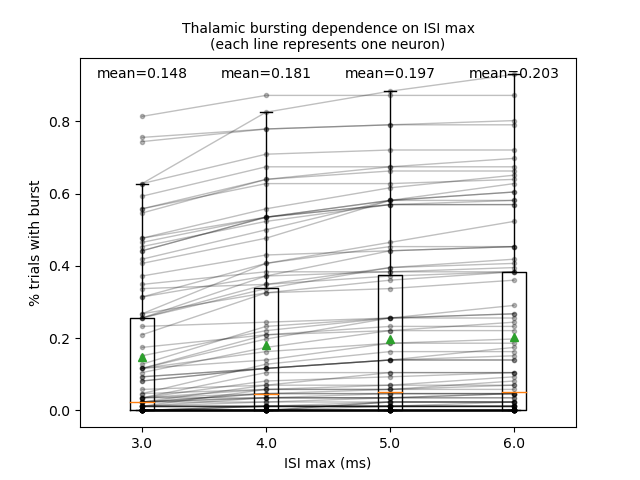

In [49]:
fig, ax = plt.subplots()
ax.plot(testISI*1E3, all_burst_trials, color='k', marker='.', linewidth=1.0, alpha=0.25)
ax.boxplot(all_burst_trials.T, positions=testISI*1E3, widths=[0.2, 0.2, 0.2, 0.2], showfliers=False, showmeans=True)
ax.set_xlabel('ISI max (ms)')
ax.set_xticks(testISI*1E3)
ax.set_ylabel('% trials with burst')
ax.set_title('Thalamic bursting dependence on ISI max\n(each line represents one neuron)')
for indi, ISI in enumerate(testISI):
    ax.annotate(
        'mean={:.3f}'.format(np.mean(all_burst_trials[indi])), xy=(ISI*1E3, 0.95),
        xycoords='data', annotation_clip=False, ha='center', va='top'
    )

## Save ##
figname = 'eventburstprob_ISImax_{}-{}.png'.format(mouse_num, group)
# fig.savefig(os.path.join(plotsdir, figname), transparent=False)

In [36]:
np.sum(all_burst_trials[1,:] == 0)

33

In [37]:
len(all_burst_trials[1,:])

100

In [38]:
np.mean(all_burst_trials[1,:])

0.18116279069767444

In [40]:
np.mean(all_burst_trials[1,:][all_burst_trials[1,:] > 0])

0.27039222492190207